In [1]:
import numpy as np
import pandas as pd

# https://www.clips.uantwerpen.be/pattern
from pattern.en import parse
from pattern.en     import tag
from pattern.vector import KNN, count

In [2]:
# Show all column in head()
pd.set_option('display.max_columns', None)

In [4]:
merged_tweet_tfidf = pd.read_csv('merged_tweet_tfidf.csv')

/home/kooud/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (15,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [175]:
merged_tweet_tfidf.head(-1)

tweetId           created_at lang  isRetweet  \
0      418443702579654656  2014-01-01 13:08:00   en      False   
1      418396495692316672  2014-01-01 10:01:00   en      False   
2      418198017015959552  2013-12-31 20:52:00   en      False   
3      418600422740197378  2014-01-01 23:31:00   en       True   
4      418765690913705984  2014-01-02 10:28:00   en       True   
...                   ...                  ...  ...        ...   
44895  715572320937517058  2016-03-31 11:11:00   en       True   
44896  715344834475614210  2016-03-30 20:07:00   en      False   
44897  715642655233941504  2016-03-31 15:51:00   en      False   
44898  715541408929693696  2016-03-31 09:09:00   en      False   
44899  715341101553618949  2016-03-30 19:53:00   en       True   

      parent_tweet_created_at  hoursDiffFromParent  tweet_userId  \
0         2014-01-01 13:08:00                    0      23059499   
1         2014-01-01 10:01:00                    0      23669783   
2         2013-12-31 20:52:00                    0      23954327   
3         2013-12-30 11:13:00                   60    1653399757   
4         2014-01-02 08:55:00                    1    1951070833   
...                       ...                  ...           ...   
44895     2016-03-31 11:08:00                    0    3220067984   
44896     2016-03-30 20:07:00                    0    1398659612   
44897     2016-03-31 15:51:00                    0    2348716116   
44898     2016-03-31 09:09:00                    0      12114462   
44899     2016-03-30 10:50:00                    9    3849844702   

       followers_count company_name afinn_verdict  afinn_score  \
0                48108         AAPL      POSITIVE            1   
1                14958         AAPL      NEGATIVE           -1   
2                17449         AAPL      POSITIVE            2   
3                   21         AAPL      POSITIVE            1   
4                    5         AAPL      POSITIVE            6   
...                ...          ...           ...          ...   
44895              950            T      NEGATIVE           -3   
44896            17775            T      NEGATIVE           -3   
44897             2139          UTX      POSITIVE            1   
44898              608            V      POSITIVE            1   
44899              930          WFC      POSITIVE            2   

       afinn_comparative  no_of_positive_words  no_of_negative_words  \
0               0.166667                     1                     0   
1              -0.142857                     1                     1   
2               0.153846                     1                     0   
3               0.066667                     1                     0   
4               0.272727                     2                     0   
...                  ...                   ...                   ...   
44895          -0.150000                     0                     2   
44896          -0.500000                     0                     1   
44897           0.090909                     1                     0   
44898           0.047619                     1                     1   
44899           0.181818                     1                     0   

      positive_words negative_words  \
0              boost            NaN   
1                big        screwed   
2        intelligent            NaN   
3               huge            NaN   
4           wins,top            NaN   
...              ...            ...   
44895            NaN   obsolete,pay   
44896            NaN           dead   
44897         united            NaN   
44898        rewards            pay   
44899        gaining            NaN   

                                            cleaned_text  \
0                        itv will boost apple aapl apple   
1                    apple screwed up big time amzn aapl   
2      iphone users are more intelligent than samsung...   
3      rt stocktwits here's how apple cou

In [176]:
core_features = ['tweetId', 'isRetweet', 'hoursDiffFromParent', 'tweet_userId', 'followers_count', 'company_name', 'afinn_verdict',
                 'no_of_positive_words', 'no_of_negative_words', 'positive_words', 'negative_words', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 
                 'volume_vs_5d_avg_vol', '5d_gain_percent', '5d_loss_percent', '20d_gain_percent', '20d_loss_percent', 'cleaned_text_new']
core_feature_df = merged_tweet_tfidf[core_features]
del merged_tweet_tfidf

top_eight_company_tweets = core_feature_df.loc[core_feature_df['company_name'].isin(['AAPL', 'AMZN', 'FB', 'GOOG', 'HSBC','INTC','MSFT', 'ORCL'])]
del core_feature_df

top_eight_company_tweets['5d_gain_percent'] = top_eight_company_tweets['5d_gain_percent'].astype('float32')
top_eight_company_tweets['5d_loss_percent'] = top_eight_company_tweets['5d_loss_percent'].astype('float32')
top_eight_company_tweets['volume_vs_5d_avg_vol'] = top_eight_company_tweets['volume_vs_5d_avg_vol'].astype('float32')

top_8comp_volume_spike = top_eight_company_tweets.loc[ (top_eight_company_tweets['followers_count']>1000)]
top_8comp_volume_spike = top_8comp_volume_spike.loc[(top_8comp_volume_spike['5d_gain_percent']>2) | (top_8comp_volume_spike['5d_loss_percent']<-2)]

In [179]:
top_eight_company_tweets.shape

(22469, 24)

In [184]:
top_8comp_volume_spike.shape

(3540, 24)

In [181]:
top_8comp_volume_spike['cleaned_text_new']

0                                iTV Will Boost Apple AAPL
1                      Apple Screwed Up Big Time AMZN AAPL
2        iPhone users are more intelligent than and HTC...
6        What are your top picks for Q  Here are mine A...
11       Will  be Apple year of innovation  or year of ...
                               ...                        
44776    Three Penny Stock Picks More Than QUADRUPLED I...
44779    Premium Alerts Ranked For Gains  Last Week At ...
44781    Apple Still into Uptrend Channel since Februar...
44785                  REVIEW This is Apple best iPad AAPL
44786    AAPL Just got this email from AppleWhy Apples ...
Name: cleaned_text_new, Length: 3540, dtype: object

In [182]:
top_8comp_volume_spike.to_csv('top_8comp_volume_spike_4_POS_NN.csv', index=False)

# Interval 

### Manual labeling

In [23]:
tweet_df = pd.read_csv('top_8comp_volume_spike_4_POS_NN_manually_labelled.csv')

In [24]:
tweet_df.head(-1)

,tweetId,isRetweet,hoursDiffFromParent,tweet_userId,followers_count,company_name,afinn_verdict,no_of_positive_words,no_of_negative_words,positive_words,negative_words,Date,Open,High,Low,Close,Adj Close,Volume,volume_vs_5d_avg_vol,5d_gain_percent,5d_loss_percent,20d_gain_percent,20d_loss_percent,cleaned_text_new,NER
0,4.180000e+17,False,0,2.366978e+07,14958,AAPL,NEGATIVE,1,1,big,screwed,12/31/2013 0:00,79.167145,80.182854,79.142860,80.145714,74.571281,55771100,0.824783,0.000000,-3.682317,0.000000,-9.996391,Apple Screwed Up Big Time,Apple
1,4.180000e+17,False,0,2.305950e+07,48081,FB,NEGATIVE,0,1,NaN,warning,12/31/2013 0:00,54.119999,54.860001,53.910000,54.650002,54.650002,43076200,0.655074,6.726208,0.000000,8.111557,-3.821187,Warning Bells Are Sounding Ever Louder For Fac...,FaceBook
2,4.190000e+17,False,0,5.924043e+07,4172,MSFT,NEGATIVE,1,2,responsibility,"anti,hacked",1/2/2014 0:00,37.349998,37.400002,37.099998,37.160000,33.690468,30632200,1.909433,0.000000,-4.097024,0.401061,-6.657674,Following SnapChat Skype twitter and blog hac...,Skype
3,4.200000e+17,True,0,5.185106e+08,250614,AMZN,NEGATIVE,0,1,NaN,killing,1/6/2014 0:00,395.850006,397.000000,388.420013,393.630005,393.630005,3170600,1.465360,2.491188,0.000000,2.785894,-12.440143,Bar Charts Apple vs Amazon vs Google AMZN GOOG...,NaN
4,4.190000e+17,True,-10,2.020527e+07,8415,FB,NEGATIVE,0,1,NaN,lawsuit,1/3/2014 0:00,55.020000,55.650002,54.529999,54.560001,54.560001,38246200,0.707881,5.947883,-0.880249,13.872411,-4.914728,Facebook is facing a lawsuit over claims it mi...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3530,7.150000e+17,False,0,7.080000e+17,1287,AAPL,POSITIVE,3,0,"gain,gain,nice",NaN,3/31/2016 0:00,109.720001,109.900002,108.879997,108.989998,105.879097,25888400,0.874377,2.083712,-0.624541,2.265693,-12.123436,Nice day for the team and I We hit AAPL for a...,NaN
3531,7.150000e+17,False,0,2.447968e+09,13804,AAPL,POSITIVE,1,0,big,NaN,3/31/2016 0:00,109.720001,109.900002,108.879997,108.989998,105.879097,25888400,0.874377,2.083712,-0.624541,2.265693,-12.123436,Three Penny Stock Picks More Than QUADRUPLED I...,NaN
3532,7.150000e+17,False,0,3.984396e+09,7096,AAPL,POSITIVE,1,0,gains,NaN,3/31/2016 0:00,109.720001,109.900002,108.879997,108.989998,105.879097,25888400,0.874377,2.083712,-0.624541,2.265693,-12.123436,Premium Alerts Ranked For Gains Last Week At ...,NaN
3533,7.160000e+17,False,0,9.505171e+08,1760,AAPL,POSITIVE,1,0,shares,NaN,3/31/2016 0:00,109.720001,109.900002,108.879997,108.989998,105.879097,25888400,0.874377,2.083712,-0.624541,2.265693,-12.123436,Apple Still into Uptrend Channel since Februar...,NaN


In [25]:
tweet_df['company_name'].unique()

array(['AAPL', 'FB', 'MSFT', 'AMZN', 'GOOG', 'INTC', 'HSBC', 'ORCL'],
      dtype=object)

In [26]:
product_dictionary = {
    'apple':'aapl', 'appl':'aapl','itv':'aapl', 'iwatch':'aapl', 
    'facebook':'fb', 'fb':'fb',
    'msft':'msft','microsoft':'msft',
    'amazon':'amzn', 'amzn':'amzn',
    'google':'goog', 'goog':'goog','youtube':'goog',
    'intc':'intc','intel':'intc',
    'hsbc':'hsbc',
    'oracle':'orcl', 'orcl':'orcl',
    'samsung':'samsung'
}

In [27]:
product_dictionary

{'apple': 'aapl',
 'appl': 'aapl',
 'itv': 'aapl',
 'iwatch': 'aapl',
 'facebook': 'fb',
 'fb': 'fb',
 'msft': 'msft',
 'microsoft': 'msft',
 'amazon': 'amzn',
 'amzn': 'amzn',
 'google': 'goog',
 'goog': 'goog',
 'youtube': 'goog',
 'intc': 'intc',
 'intel': 'intc',
 'hsbc': 'hsbc',
 'oracle': 'orcl',
 'orcl': 'orcl',
 'samsung': 'samsung'}

In [28]:
def listToString(aList):
    # initialize an empty string 
    str1 = ""  
    
    # traverse in the string   
    for ele in aList:  
        str1 += str(ele)
    
    # return string   
    return str1  

def list2Str2(aList):
    return ','.join([str(elem) for elem in aList]) 

In [29]:
def markNER(tweetId=1, tweet_text='', company_name='', positive_words='', negatve_words='', rowIndex=-1):
    #print(positive_words)
    #print(negatve_words)
    retList = []
    s = parse(tweet_text, relations=False, lemmata=False)
    i=1
    for word, pos in tag(s):
        x = word.split("/")
        retList.append(x[1].split("-")[0])
        
        # Locate object of interest
        company_of_interest = product_dictionary.get(x[0].lower())
        if company_of_interest==None:
            retList.append(0)
        else:
            if company_of_interest==company_name.lower():
                retList.append(1) 
            else:
                retList.append(-1) # Opponent
        # Find +ve or -ve words        
        if (x[0].lower() in positive_words.lower()):
            retList.append(1)
        elif (x[0].lower() in negatve_words.lower()):
            retList.append(-1)
        else:
            retList.append(0)
        #tweet_df.loc[(tweet_df.tweetId==tweetId),'Sales'] = x[0]
        #print(x[0])
        #print(x[1].split("-")[0])
    #print(retList)
    return retList

In [30]:
def parseRowMarkNER(aRow):
    #print(aRow['cleaned_text_new'])
    tweet_text = aRow['cleaned_text_new']
    company_name = aRow['company_name']
    positive_words = aRow['positive_words']
    negative_words = aRow['negative_words']
    if (pd.isnull(positive_words)):
        positive_words = ''
    if (pd.isnull(negative_words)):
        negative_words = ''
    #print(pd.isnull(positive_words))
    #print(type(aRow.index))
    return markNER(aRow['tweetId'], tweet_text, company_name, positive_words, negative_words, aRow.index)  

tweet_df['pos_ner'] = tweet_df.apply(parseRowMarkNER, axis = 1) 

In [31]:
tags = tweet_df['pos_ner'].apply(pd.Series)

# rename each variable is tags
tags = tags.rename(columns = lambda x : 'tag_' + str(x))

word_pos_count=0
for i in range(0, 90, 3):
    tags = tags.rename(columns={
        'tag_'+str(i): 'tag_'+ str(word_pos_count), 
        'tag_'+str(i+1): 'tag_'+ str(word_pos_count) +'_coi', 
        'tag_'+str(i+2): 'tag_'+ str(word_pos_count) +'_sentiment'})
    word_pos_count=word_pos_count+1

In [32]:
tags

,tag_0,tag_0_coi,tag_0_sentiment,tag_1,tag_1_coi,tag_1_sentiment,tag_2,tag_2_coi,tag_2_sentiment,tag_3,tag_3_coi,tag_3_sentiment,tag_4,tag_4_coi,tag_4_sentiment,tag_5,tag_5_coi,tag_5_sentiment,tag_6,tag_6_coi,tag_6_sentiment,tag_7,tag_7_coi,tag_7_sentiment,tag_8,tag_8_coi,tag_8_sentiment,tag_9,tag_9_coi,tag_9_sentiment,tag_10,tag_10_coi,tag_10_sentiment,tag_11,tag_11_coi,tag_11_sentiment,tag_12,tag_12_coi,tag_12_sentiment,tag_13,tag_13_coi,tag_13_sentiment,tag_14,tag_14_coi,tag_14_sentiment,tag_15,tag_15_coi,tag_15_sentiment,tag_16,tag_16_coi,tag_16_sentiment,tag_17,tag_17_coi,tag_17_sentiment,tag_18,tag_18_coi,tag_18_sentiment,tag_19,tag_19_coi,tag_19_sentiment,tag_20,tag_20_coi,tag_20_sentiment,tag_21,tag_21_coi,tag_21_sentiment,tag_22,tag_22_coi,tag_22_sentiment,tag_23,tag_23_coi,tag_23_sentiment,tag_24,tag_24_coi,tag_24_sentiment,tag_25,tag_25_coi,tag_25_sentiment,tag_26,tag_26_coi,tag_26_sentiment,tag_27,tag_27_coi,tag_27_sentiment,tag_28,tag_28_coi,tag_28_sentiment,tag_29,tag_29_coi,tag_29_sentiment
0,NNP,1,0,JJ,0,-1,NNP,0.0,0.0,NNP,0.0,1.0,NNP,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NNP,0,-1,NNP,0,0,NNP,0.0,0.0,NNP,0.0,0.0,RB,0.0,0.0,JJR,0.0,0.0,IN,0.0,0.0,NNP,1.0,0.0,NNP,0.0,0.0,NNP,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VBG,0,0,RB,0,0,NNP,0.0,0.0,NNP,0.0,0.0,CC,0.0,0.0,NN,0.0,0.0,VBD,0.0,-1.0,JJ,0.0,0.0,NNP,0.0,0.0,NNP,0.0,0.0,VBZ,0.0,0.0,NN,0.0,1.0,NNS,0.0,0.0,TO,0.0,0.0,VB,0.0,0.0,IN,0.0,-1.0,NNP,1.0,0.0,NN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NNP,0,0,NNS,0,0,NNP,-1.0,0.0,NNP,0.0,0.0,NNP,1.0,0.0,NNP,0.0,0.0,NNP,-1.0,0.0,NNP,1.0,0.0,NNP,-1.0,0.0,RB,0.0,0.0,NN,0.0,0.0,NN,0.0,0.0,NN,0.0,-1.0,NNP,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NNP,1,0,VBZ,0,0,VBG,0.0,0.0,DT,0.0,-1.0,NN,0.0,-1.0,IN,0.0,0.0,NNS,0.0,0.0,PRP,0.0,-1.0,NNS,0.0,0.0,JJ,0.0,0.0,NNS,0.0,0.0,IN,0.0,0.0,NN,0.0,0.0,WDT,0.0,0.0,VBZ,0.0,0.0,RB,0.0,0.0,VBD,0.0,0.0,TO,0.0,0.0,JJ,0.0,0.0,NNS,0.0,0.0,NNP,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531,NNP,0,0,NNP,0,0,NNP,0.0,0.0,VBZ,0.0,0.0,RBR,0.0,0.0,IN,0.0,0.0,JJ,0.0,0.0,IN,0.0,0.0,NNP,0.0,0.0,NNP,0.0,0.0,NNP,0.0,1.0,NNS,0.0,0.0,IN,0.0,0.0,DT,0.0,0.0,NNP,0.0,0.0,NNP,0.0,0.0,NNP,0.0,0.0,NNP,-1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3532,NNP,0,0,NNP,0,0,VBN,0.0,0.0,IN,0.0,0.0,NNS,0.0,1.0,JJ,0.0,0.0,NN,0.0,0.0,IN,0.0,0.0,NNP,0.0,0.0,NNP,0.0,0.0,NNP,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3533,NNP,1,0,RB,0,0,IN,0.0,0.0,NNP,0.0,0.0,NNP,0.0,0.0,IN,0.0,0.0,NNP,0.0,0.0,IN,0.0,0.0,NNP,1.0,0.0,NNP,0.0,1.0,NNP,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [33]:
# join the tags dataframe back to the original dataframe
final_pos_df = pd.concat([tweet_df[['company_name', 'afinn_verdict', 'cleaned_text_new']], tags[:]], axis=1)

In [34]:
final_pos_df.head()

,company_name,afinn_verdict,cleaned_text_new,tag_0,tag_0_coi,tag_0_sentiment,tag_1,tag_1_coi,tag_1_sentiment,tag_2,tag_2_coi,tag_2_sentiment,tag_3,tag_3_coi,tag_3_sentiment,tag_4,tag_4_coi,tag_4_sentiment,tag_5,tag_5_coi,tag_5_sentiment,tag_6,tag_6_coi,tag_6_sentiment,tag_7,tag_7_coi,tag_7_sentiment,tag_8,tag_8_coi,tag_8_sentiment,tag_9,tag_9_coi,tag_9_sentiment,tag_10,tag_10_coi,tag_10_sentiment,tag_11,tag_11_coi,tag_11_sentiment,tag_12,tag_12_coi,tag_12_sentiment,tag_13,tag_13_coi,tag_13_sentiment,tag_14,tag_14_coi,tag_14_sentiment,tag_15,tag_15_coi,tag_15_sentiment,tag_16,tag_16_coi,tag_16_sentiment,tag_17,tag_17_coi,tag_17_sentiment,tag_18,tag_18_coi,tag_18_sentiment,tag_19,tag_19_coi,tag_19_sentiment,tag_20,tag_20_coi,tag_20_sentiment,tag_21,tag_21_coi,tag_21_sentiment,tag_22,tag_22_coi,tag_22_sentiment,tag_23,tag_23_coi,tag_23_sentiment,tag_24,tag_24_coi,tag_24_sentiment,tag_25,tag_25_coi,tag_25_sentiment,tag_26,tag_26_coi,tag_26_sentiment,tag_27,tag_27_coi,tag_27_sentiment,tag_28,tag_28_coi,tag_28_sentiment,tag_29,tag_29_coi,tag_29_sentiment
0,AAPL,NEGATIVE,Apple Screwed Up Big Time,NNP,1,0,JJ,0,-1,NNP,0.0,0.0,NNP,0.0,1.0,NNP,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FB,NEGATIVE,Warning Bells Are Sounding Ever Louder For Fac...,NNP,0,-1,NNP,0,0,NNP,0.0,0.0,NNP,0.0,0.0,RB,0.0,0.0,JJR,0.0,0.0,IN,0.0,0.0,NNP,1.0,0.0,NNP,0.0,0.0,NNP,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MSFT,NEGATIVE,Following SnapChat Skype twitter and blog hac...,VBG,0,0,RB,0,0,NNP,0.0,0.0,NNP,0.0,0.0,CC,0.0,0.0,NN,0.0,0.0,VBD,0.0,-1.0,JJ,0.0,0.0,NNP,0.0,0.0,NNP,0.0,0.0,VBZ,0.0,0.0,NN,0.0,1.0,NNS,0.0,0.0,TO,0.0,0.0,VB,0.0,0.0,IN,0.0,-1.0,NNP,1.0,0.0,NN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AMZN,NEGATIVE,Bar Charts Apple vs Amazon vs Google AMZN GOOG...,NNP,0,0,NNS,0,0,NNP,-1.0,0.0,NNP,0.0,0.0,NNP,1.0,0.0,NNP,0.0,0.0,NNP,-1.0,0.0,NNP,1.0,0.0,NNP,-1.0,0.0,RB,0.0,0.0,NN,0.0,0.0,NN,0.0,0.0,NN,0.0,-1.0,NNP,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FB,NEGATIVE,Facebook is facing a lawsuit over claims it mi...,NNP,1,0,VBZ,0,0,VBG,0.0,0.0,DT,0.0,-1.0,NN,0.0,-1.0,IN,0.0,0.0,NNS,0.0,0.0,PRP,0.0,-1.0,NNS,0.0,0.0,JJ,0.0,0.0,NNS,0.0,0.0,IN,0.0,0.0,NN,0.0,0.0,WDT,0.0,0.0,VBZ,0.0,0.0,RB,0.0,0.0,VBD,0.0,0.0,TO,0.0,0.0,JJ,0.0,0.0,NNS,0.0,0.0,NNP,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
allPos = []
for i in range(0, 30, 1):
    allPos = allPos + list(final_pos_df['tag_'+str(i)].unique())
    
allPos = list(dict.fromkeys(allPos))

In [36]:
allPos

['NNP',
 'VBG',
 'RB',
 'NN',
 'DT',
 'IN',
 'JJ',
 'JJS',
 'VBD',
 'EX',
 'VB',
 'NNS',
 'PRP',
 'CC',
 'WRB',
 'MD',
 'VBP',
 'PRP$',
 'VBN',
 'WP',
 'VBZ',
 'UH',
 'JJR',
 'WDT',
 'CD',
 'TO',
 'NNPS',
 'RBR',
 'PDT',
 'RP',
 'FW',
 'RBS',
 nan,
 'WP$',
 'NN|NNS']

In [37]:
pos_encoder = {
    'Padding' :-2,
    'NEGATIVE':-1,
    'NEUTRAL':0,
    'POSITIVE':1,
    
    'VBG':2,
    'RB' :3,
    'NN' :4,
    'NN|NNS':4,
    'NNP':5,    
    'DT' :6,
    'IN' :7,
    'JJ' :8,
    'JJS':9,
    'VBD':10,
    'EX' :11,
    'VB' :12,
    'NNS':13,
    'PRP':14,
    'CC' :15,
    'WRB':16,
    'MD' :17,
    'VBP':18,
    'PRP$':19,
    'VBN' :20,
    'WP'  :21,
    'VBZ' :22,
    'UH' :23,
    'JJR' :24,
    'WDT' :25,
    'CD' :26,
    'TO' :27,
    'NNPS' :28,
    'RBR' :29,
    'PDT' :30,    
    'RBS' :31,
    'RP' :32,
    'FW' :33,
    'WP$':34
    
}

In [38]:
for i in range(0, 30, 1):
    final_pos_df['tag_'+str(i)] = final_pos_df['tag_'+str(i)].map(pos_encoder)
    #final_pos_df['tag_'+str(i+3)] = final_pos_df['tag_'+str(i)].map(pos_encoder)


In [39]:
final_pos_df.head()

,company_name,afinn_verdict,cleaned_text_new,tag_0,tag_0_coi,tag_0_sentiment,tag_1,tag_1_coi,tag_1_sentiment,tag_2,tag_2_coi,tag_2_sentiment,tag_3,tag_3_coi,tag_3_sentiment,tag_4,tag_4_coi,tag_4_sentiment,tag_5,tag_5_coi,tag_5_sentiment,tag_6,tag_6_coi,tag_6_sentiment,tag_7,tag_7_coi,tag_7_sentiment,tag_8,tag_8_coi,tag_8_sentiment,tag_9,tag_9_coi,tag_9_sentiment,tag_10,tag_10_coi,tag_10_sentiment,tag_11,tag_11_coi,tag_11_sentiment,tag_12,tag_12_coi,tag_12_sentiment,tag_13,tag_13_coi,tag_13_sentiment,tag_14,tag_14_coi,tag_14_sentiment,tag_15,tag_15_coi,tag_15_sentiment,tag_16,tag_16_coi,tag_16_sentiment,tag_17,tag_17_coi,tag_17_sentiment,tag_18,tag_18_coi,tag_18_sentiment,tag_19,tag_19_coi,tag_19_sentiment,tag_20,tag_20_coi,tag_20_sentiment,tag_21,tag_21_coi,tag_21_sentiment,tag_22,tag_22_coi,tag_22_sentiment,tag_23,tag_23_coi,tag_23_sentiment,tag_24,tag_24_coi,tag_24_sentiment,tag_25,tag_25_coi,tag_25_sentiment,tag_26,tag_26_coi,tag_26_sentiment,tag_27,tag_27_coi,tag_27_sentiment,tag_28,tag_28_coi,tag_28_sentiment,tag_29,tag_29_coi,tag_29_sentiment
0,AAPL,NEGATIVE,Apple Screwed Up Big Time,5,1,0,8,0,-1,5.0,0.0,0.0,5.0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FB,NEGATIVE,Warning Bells Are Sounding Ever Louder For Fac...,5,0,-1,5,0,0,5.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,24.0,0.0,0.0,7.0,0.0,0.0,5.0,1.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MSFT,NEGATIVE,Following SnapChat Skype twitter and blog hac...,2,0,0,3,0,0,5.0,0.0,0.0,5.0,0.0,0.0,15.0,0.0,0.0,4.0,0.0,0.0,10.0,0.0,-1.0,8.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,22.0,0.0,0.0,4.0,0.0,1.0,13.0,0.0,0.0,27.0,0.0,0.0,12.0,0.0,0.0,7.0,0.0,-1.0,5.0,1.0,0.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AMZN,NEGATIVE,Bar Charts Apple vs Amazon vs Google AMZN GOOG...,5,0,0,13,0,0,5.0,-1.0,0.0,5.0,0.0,0.0,5.0,1.0,0.0,5.0,0.0,0.0,5.0,-1.0,0.0,5.0,1.0,0.0,5.0,-1.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,-1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FB,NEGATIVE,Facebook is facing a lawsuit over claims it mi...,5,1,0,22,0,0,2.0,0.0,0.0,6.0,0.0,-1.0,4.0,0.0,-1.0,7.0,0.0,0.0,13.0,0.0,0.0,14.0,0.0,-1.0,13.0,0.0,0.0,8.0,0.0,0.0,13.0,0.0,0.0,7.0,0.0,0.0,4.0,0.0,0.0,25.0,0.0,0.0,22.0,0.0,0.0,3.0,0.0,0.0,10.0,0.0,0.0,27.0,0.0,0.0,8.0,0.0,0.0,13.0,0.0,0.0,5.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
final_pos_df = final_pos_df.fillna(-2)

# LSTM

In [41]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from sklearn.manifold import TSNE

Using TensorFlow backend.
/home/kooud/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kooud/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kooud/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kooud/anaconda3/lib/python3.7/site-packages/tensorflo

In [201]:
data = final_pos_df.drop(['company_name', 'afinn_verdict', 'cleaned_text_new'], axis=1)

In [202]:
data = data.values
labels = final_pos_df['afinn_verdict'].map({'POSITIVE':1, 'NEGATIVE':0})

In [67]:
## Network architecture
model = Sequential()
model.add(Embedding(35, 90, input_length=90))
model.add(LSTM(90, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [69]:
## Fit the model
history = model.fit(data, np.array(labels), validation_split=0.2, epochs=5)### Training output

Train on 2828 samples, validate on 708 samples
Epoch 1/5
2828/2828 [==============================] - 6s 2ms/step - loss: 0.6694 - accuracy: 0.6100 - val_loss: 0.4948 - val_accuracy: 1.0000
Epoch 2/5
2828/2828 [==============================] - 6s 2ms/step - loss: 0.6699 - accuracy: 0.6107 - val_loss: 0.5184 - val_accuracy: 1.0000
Epoch 3/5
2828/2828 [==============================] - 6s 2ms/step - loss: 0.6691 - accuracy: 0.6096 - val_loss: 0.5115 - val_accuracy: 1.0000
Epoch 4/5
2828/2828 [==============================] - 6s 2ms/step - loss: 0.6690 - accuracy: 0.6100 - val_loss: 0.4805 - val_accuracy: 1.0000
Epoch 5/5
2828/2828 [==============================] - 6s 2ms/step - loss: 0.6690 - accuracy: 0.6107 - val_loss: 0.5055 - val_accuracy: 0.9986


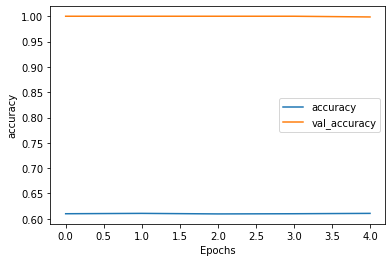

In [71]:
plot_graphs(history, 'accuracy')

In [209]:
del model
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(35, 100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dense(35, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [210]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

In [211]:
history  = model.fit(data, np.array(labels), validation_split=0.4, epochs=10)### Training output

Train on 2121 samples, validate on 1415 samples
Epoch 1/10
2121/2121 [==============================] - 19s 9ms/sample - loss: 0.6910 - acc: 0.5450 - val_loss: 0.5642 - val_acc: 1.0000
Epoch 2/10
2121/2121 [==============================] - 16s 7ms/sample - loss: 0.5925 - acc: 0.6869 - val_loss: 0.3041 - val_acc: 0.9491
Epoch 3/10
2121/2121 [==============================] - 16s 7ms/sample - loss: 0.4965 - acc: 0.7803 - val_loss: 0.7916 - val_acc: 0.5661
Epoch 4/10
2121/2121 [==============================] - 16s 7ms/sample - loss: 0.4707 - acc: 0.7888 - val_loss: 0.4968 - val_acc: 0.8367
Epoch 5/10
2121/2121 [==============================] - 16s 7ms/sample - loss: 0.4362 - acc: 0.8105 - val_loss: 0.5687 - val_acc: 0.7837
Epoch 6/10
2121/2121 [==============================] - 16s 7ms/sample - loss: 0.3883 - acc: 0.8458 - val_loss: 0.2915 - val_acc: 0.9364
Epoch 7/10
2121/2121 [==============================] - 16s 7ms/sample - loss: 0.3135 - acc: 0.8793 - val_loss: 0.3298 - val_acc: 

In [212]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


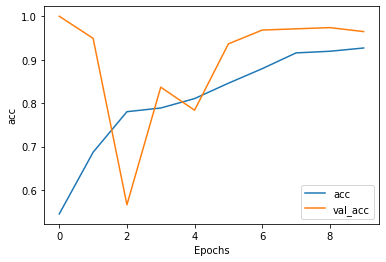

In [213]:
plot_graphs(history, 'acc')

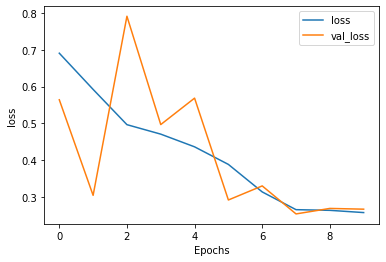

In [214]:
plot_graphs(history, 'loss')